# MODELLING
A notebook to model the problem

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import joblib
import copy
import pandas as pd
import numpy as np
import os
PRJ_ROOT_DIR = os.path.dirname(os.path.abspath(''))

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# Where to save the figures
NOTE_ROOT_DIR = os.path.abspath('')
CHAPTER_ID = "04_modelling"
IMAGES_PATH = os.path.join(NOTE_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1 - Load the Data

In [3]:
# Load the integrated data
df_match = pd.read_csv(os.path.join(PRJ_ROOT_DIR, "data", "tabular", "integrate", "matches.csv"))
df_match.drop(['season'], axis=1, inplace=True)
df_match.head()

,home_result,defence/clean_sheets_0,defence/goals_conceded_0,defence/tackles_0,defence/tackle_success_%_0,defence/last_man_tackles_0,defence/blocked_shots_0,defence/interceptions_0,defence/clearances_0,defence/headed_clearance_0,...,goalkeeping/catches_26,goalkeeping/sweeper_clearances_26,goalkeeping/throw_outs_26,goalkeeping/goal_kicks_26,defence/recoveries_26,defence/duels_won_26,defence/duels_lost_26,teamplay/passes_26,teamplay/crosses_26,teamplay/accurate_long_balls_26
0,lose,5.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1097.0,88.0,0.0
1,win,6.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2,win,13.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
3,win,11.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,248.0,13.0,0.0
4,win,13.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0


### 1.1. Manage Empty Positions' Statistics

In [4]:
# Replace -100 with 0 (statistics' value of empty positions)
df_match = df_match.replace(-100, 0)
df_match.head()

,home_result,defence/clean_sheets_0,defence/goals_conceded_0,defence/tackles_0,defence/tackle_success_%_0,defence/last_man_tackles_0,defence/blocked_shots_0,defence/interceptions_0,defence/clearances_0,defence/headed_clearance_0,...,goalkeeping/catches_26,goalkeeping/sweeper_clearances_26,goalkeeping/throw_outs_26,goalkeeping/goal_kicks_26,defence/recoveries_26,defence/duels_won_26,defence/duels_lost_26,teamplay/passes_26,teamplay/crosses_26,teamplay/accurate_long_balls_26
0,lose,5.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1097.0,88.0,0.0
1,win,6.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,win,13.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,win,11.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,248.0,13.0,0.0
4,win,13.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.2 Create a Test Set

In [5]:
# Split train-test
from sklearn.model_selection import train_test_split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(df_match.iloc[:, 1:], df_match["home_result"], test_size=test_size, random_state=42)
X_train.head()

,defence/clean_sheets_0,defence/goals_conceded_0,defence/tackles_0,defence/tackle_success_%_0,defence/last_man_tackles_0,defence/blocked_shots_0,defence/interceptions_0,defence/clearances_0,defence/headed_clearance_0,defence/clearances_off_line_0,...,goalkeeping/catches_26,goalkeeping/sweeper_clearances_26,goalkeeping/throw_outs_26,goalkeeping/goal_kicks_26,defence/recoveries_26,defence/duels_won_26,defence/duels_lost_26,teamplay/passes_26,teamplay/crosses_26,teamplay/accurate_long_balls_26
872,8.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
626,10.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
617,9.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
409,11.0,37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
589,9.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.3 - Preprocessing

In [6]:
# Setup the pipeline of preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

pipe_predictor_preprocess = Pipeline([
    ("scaler", StandardScaler())
])
pipe_label_preprocess = Pipeline([
    ("encoder", OrdinalEncoder())
])

In [7]:
# Transform the training data
X_prep = pipe_predictor_preprocess.fit_transform(X_train)
y_prep = pipe_label_preprocess.fit_transform(y_train.values.reshape(-1, 1))
pipe_label_preprocess["encoder"].categories_

[array(['draw', 'lose', 'win'], dtype=object)]

## 2 - Modelling

In [57]:
# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Import metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Import cross-validation and tuning tools
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform
from skopt import BayesSearchCV
from skopt.space import Real

# Setup to save/load the model
def save_model(model, id_):
    print("Saving model", id_)
    joblib.dump(model, os.path.join(NOTE_ROOT_DIR, "models", id_ + ".pkl"))
def load_model(id_):
    print("Loading model", id_)
    return joblib.load(os.path.join(NOTE_ROOT_DIR, "models", id_ + ".pkl"))

# Setup display
def report(model, X_train=X_prep, y_train=y_prep.squeeze()):
    print("======")
    print("Accuracy:", accuracy_score(y_train, model.predict(X_train)))
    print("ROC AUC :", roc_auc_score(y_train, model.predict_proba(X_train), multi_class="ovo", average="macro"))
    print("======")

# Setup cross-validation
def cross_validate(model, X_train=X_prep, y_train=y_prep, scoring="roc_auc_ovo", cv=5):
    return cross_val_score(model, X_train, y_train.squeeze(), scoring=scoring, cv=cv, n_jobs=-1).mean()

# Setup hyperparameter tuning
def bayes_search(
    model,
    search_spaces,
    X=X_prep,
    y=y_prep,
    n_iter=50,
    cv=5,
    scoring="roc_auc_ovo",
    random_state=42,
    verbose=0
):
    search = BayesSearchCV(model, search_spaces, 
                           n_iter=n_iter, cv=cv, scoring=scoring, 
                           random_state=random_state, n_jobs=-1, verbose=verbose)
    search.fit(X, y.squeeze())
    print("======")
    print("Best score :", search.best_score_)
    print("Best params:", search.best_params_)
    print("======")
    return search

### 2.1 - Train the Models

#### Logistic Regression

In [21]:
# Train logistic regression
log_reg = LogisticRegression(multi_class="multinomial")
log_reg.fit(X_prep, y_prep)

LogisticRegression(multi_class='multinomial')

In [27]:
# Evaluate training
report(log_reg)

Accuracy: 1.0
ROC AUC : 1.0


In [31]:
# K-fold cross validation on the model
cross_validate(log_reg)

0.5729353167359815

#### SVC

In [35]:
# Train svc
svc = SVC(probability=True, random_state=42)
svc.fit(X_prep, y_prep)

SVC(probability=True, random_state=42)

In [36]:
# Evaluate training
report(svc)

Accuracy: 0.8825581395348837
ROC AUC : 0.9891274574960862


In [37]:
# K-fold cross validation on the model
cross_validate(svc)

0.6402337704147287

#### Decision Tree

In [38]:
# Train decision tree
tree_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_clf.fit(X_prep, y_prep)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [39]:
# Evaluate training
report(tree_clf)

Accuracy: 0.9244186046511628
ROC AUC : 0.9808540410727377


In [40]:
# K-fold cross validation on the model
cross_validate(tree_clf)

0.5572019589238886

In [41]:
# Measure importance of features
tree_clf.feature_importances_[np.where(tree_clf.feature_importances_ > 0.0)[0]] # 109 features

array([0.00925434, 0.00418649, 0.00293789, 0.03876008, 0.01403982,
       0.02051275, 0.01127566, 0.01307069, 0.00899983, 0.00758954,
       0.01221059, 0.00587577, 0.00433688, 0.01186234, 0.00220342,
       0.0079323 , 0.00426912, 0.00763327, 0.0135074 , 0.00220342,
       0.00837298, 0.00220342, 0.00963734, 0.00352546, 0.00220342,
       0.00801242, 0.00352546, 0.01109928, 0.00724106, 0.01226957,
       0.00896826, 0.0051413 , 0.00899828, 0.0145266 , 0.00330512,
       0.00762726, 0.01008675, 0.00803855, 0.01214806, 0.00741149,
       0.01285132, 0.01035929, 0.00587577, 0.00293789, 0.00855326,
       0.01041901, 0.01694298, 0.00352546, 0.00792406, 0.00584067,
       0.01459291, 0.00293789, 0.01008063, 0.01249826, 0.00781211,
       0.00428442, 0.00330512, 0.00377728, 0.00396615, 0.0040396 ,
       0.01982649, 0.0051413 , 0.00685507, 0.00396615, 0.01246766,
       0.06220863, 0.00293789, 0.00979296, 0.00837236, 0.00769406,
       0.00846803, 0.00396615, 0.02147712, 0.00396615, 0.00705

In [44]:
# Tran a linear SVC with tree-important features
X_prep_signify = X_prep[:, np.where(tree_clf.feature_importances_ > 0.0)[0]]
svc_tree = SVC(probability=True, C=0.001, random_state=42)
svc_tree.fit(X_prep_signify, y_prep)
report(svc_tree, X_train=X_prep_signify)

Accuracy: 0.41511627906976745
ROC AUC : 0.8957467746921649


In [45]:
# Evaluate the model trained on tree-important features
cross_validate(svc_tree, X_train=X_prep_signify)

0.6502591707257948

#### Random Forest

In [46]:
# Train random forest
rand_forest = RandomForestClassifier(random_state=42)
rand_forest.fit(X_prep, y_prep)

RandomForestClassifier(random_state=42)

In [47]:
# Evaluate training
report(rand_forest)

Accuracy: 1.0
ROC AUC : 1.0


In [48]:
# Measure importance of features
cross_validate(rand_forest)

0.6348500683089926

#### AdaBoost

In [49]:
# Train ada boosting
ada_clf = AdaBoostClassifier(learning_rate=0.7, n_estimators=100)
ada_clf.fit(X_prep, y_prep)

AdaBoostClassifier(learning_rate=0.7, n_estimators=100)

In [50]:
# Evaluate training
report(ada_clf)

Accuracy: 0.7523255813953489
ROC AUC : 0.873429753045773


In [51]:
# K-fold cross validation on the model
cross_validate(ada_clf)

0.5916090005100083

#### Gradient Boosting

In [52]:
# Train gradient boosting
grad_clf = GradientBoostingClassifier(learning_rate=0.7, random_state=42)
grad_clf.fit(X_prep, y_prep)

GradientBoostingClassifier(learning_rate=0.7, random_state=42)

In [53]:
# Evaluate training
report(grad_clf)

Accuracy: 1.0
ROC AUC : 1.0


In [54]:
# K-fold cross validation on the model
cross_validate(grad_clf)

0.6106274460572148

### 2.2 - Fine-tune the Hyperparameters
**NOTE:** `BayesSearchCV` is used to tune the hyperparameters of the models.

#### Decision Tree

In [60]:
# Perform bayes search
tree_param_dist = {
    "max_depth": (3, 19), # 19 overfits the data
    "splitter": ["best", "random"],
    "min_samples_split": (2, 20),
    "max_features": [None, "sqrt", "log2"],
    "max_leaf_nodes": (20, 159),
    "min_impurity_decrease": (1e-6, 0.5, "uniform")
}
tree_search = bayes_search(DecisionTreeClassifier(random_state=42), tree_param_dist)

Best score : 0.601709239907786
Best params: OrderedDict([('max_depth', 19), ('max_features', None), ('max_leaf_nodes', 159), ('min_impurity_decrease', 0.011386093015217117), ('min_samples_split', 20), ('splitter', 'best')])


In [61]:
# Save the best model
save_model(tree_search.best_estimator_, "tree_bayes_search")

Saving model tree_bayes_search


#### Random Forest

In [62]:
# Perform bayes search
forest_param_dist = {
    "n_estimators": (10, 500), 
    "criterion": ["gini", "entropy"],
    "max_depth": (1, 15), # 19 overfits the data
    "min_samples_split": (2, 50),
    "max_features": [None, "sqrt", "log2"],
    "max_leaf_nodes": (2, 200),
    "min_impurity_decrease": (1e-6, 0.5, "uniform"),
    "max_samples": (0.25, 1.0, "uniform")
}
forest_search = bayes_search(RandomForestClassifier(random_state=42), forest_param_dist)

Best score : 0.6527739789678144
Best params: OrderedDict([('criterion', 'entropy'), ('max_depth', 10), ('max_features', None), ('max_leaf_nodes', 159), ('max_samples', 0.5), ('min_impurity_decrease', 1e-06), ('min_samples_split', 20), ('n_estimators', 200)])


In [63]:
# Save the best model
save_model(forest_search.best_estimator_, "forest_bayes_search")

Saving model forest_bayes_search


#### AdaBoost

In [64]:
# Perform bayes search
ada_param_dist = {
    "n_estimators": (2, 500),
    "learning_rate": Real(low=0.001, high=3,  prior='uniform')
}
ada_search = bayes_search(AdaBoostClassifier(random_state=42), ada_param_dist)

Best score : 0.6169811186176355
Best params: OrderedDict([('learning_rate', 0.05504257554206666), ('n_estimators', 500)])


In [65]:
# Save the best model
save_model(ada_search.best_estimator_, "ada_bayes_search")

Saving model ada_bayes_search


#### Gradient Boosting

In [67]:
# Perform bayes search
grad_param_dist = {
    "n_estimators": (2, 100),
    "learning_rate": Real(low=0.001, high=3, prior="uniform"),
    "subsample": Real(low=0.05, high=1.0, prior="uniform"),
    "criterion": ["friedman_mse", "squared_error"],
    "min_samples_split": Real(low=1e-6, high=1.0, prior="uniform"),
    "max_depth": (1, 10),
    "min_impurity_decrease": Real(low=1e-6, high=0.5, prior="uniform"),
    "max_features": [None, "sqrt", "log2"],
    "max_leaf_nodes": (2, 100),
}
grad_search = bayes_search(GradientBoostingClassifier(random_state=42), grad_param_dist)

Best score : 0.6435596396083854
Best params: OrderedDict([('criterion', 'friedman_mse'), ('learning_rate', 0.03925902260699544), ('max_depth', 9), ('max_features', 'sqrt'), ('max_leaf_nodes', 14), ('min_impurity_decrease', 0.031512640562430444), ('min_samples_split', 0.024545207590912655), ('n_estimators', 95), ('subsample', 0.8794717017195449)])


In [68]:
# Save the best model
save_model(grad_search.best_estimator_, "grad_bayes_search")

Saving model grad_bayes_search


#### SVC

In [69]:
# Perform bayes search on kernel SVM
svc_param_dist = {
    "C": Real(low=1e-4, high=2, prior="uniform"),
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": (2, 30),
    "gamma": ["scale", "auto"]
}
svc_search = bayes_search(SVC(decision_function_shape="ovo", probability=True, random_state=42), svc_param_dist)

Best score : 0.6447276526859074
Best params: OrderedDict([('C', 0.0001), ('degree', 30), ('gamma', 'auto'), ('kernel', 'sigmoid')])


In [70]:
# Save the best model
save_model(svc_search.best_estimator_, "svc_bayes_search")

Saving model svc_bayes_search


## 3 - Post-analyze the Best Models

In [71]:
# Load the best model - Random forest
forest_bayes_search = load_model("forest_bayes_search")

Loading model forest_bayes_search


Saving figure feat_importances_mdi


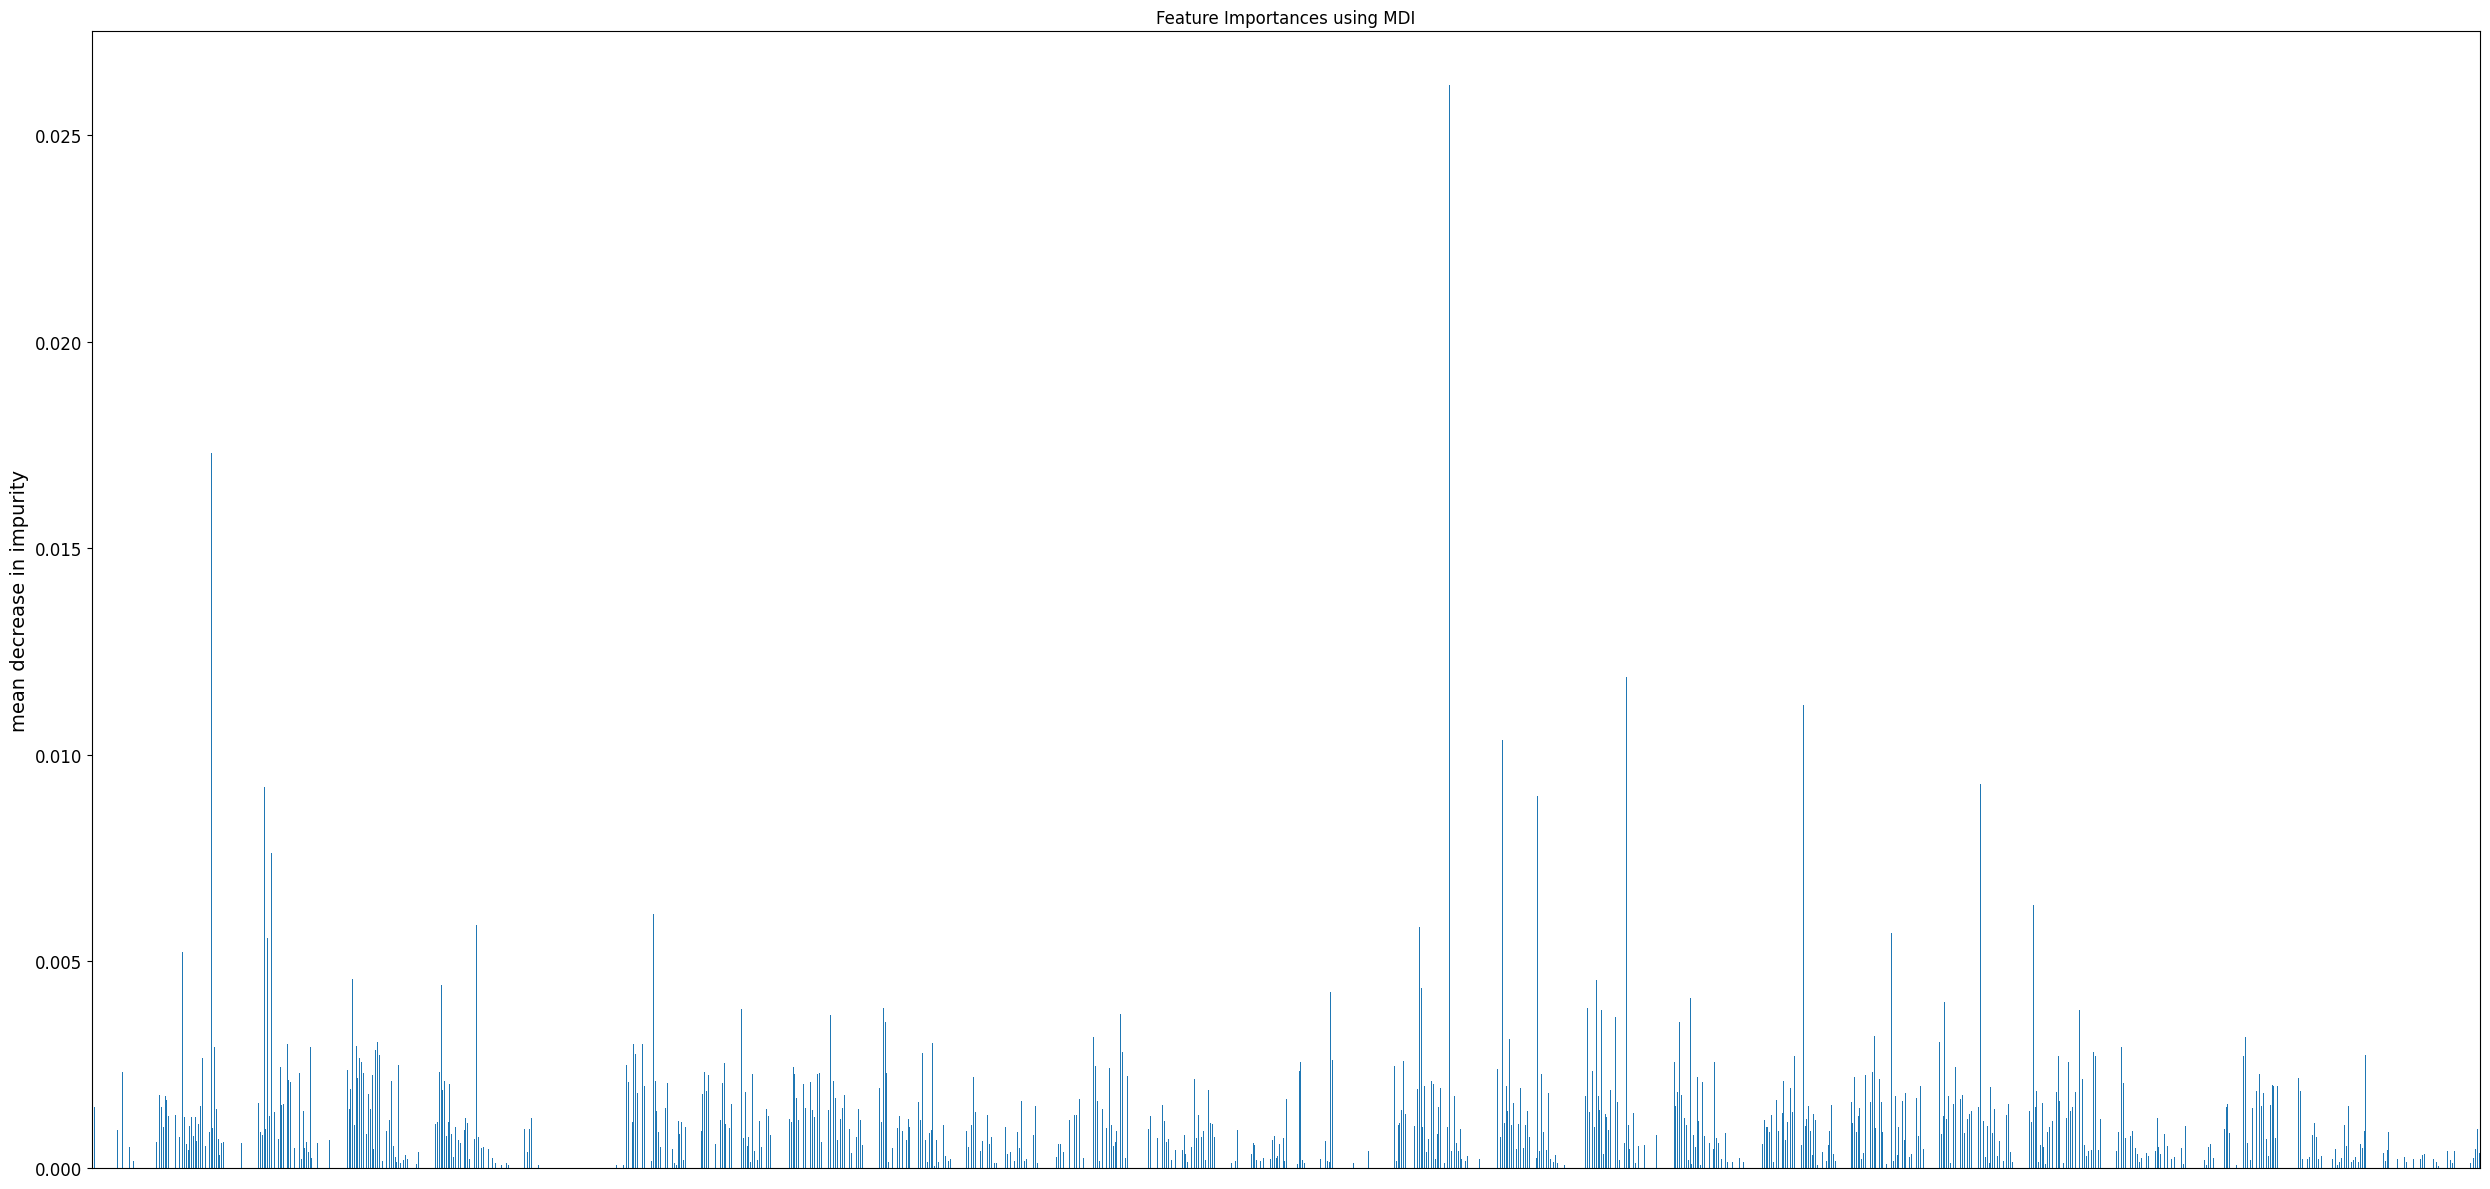

In [72]:
# Measure feature importance
def plot_feature_importances(importances, feat_names):
    df_importances = pd.Series(importances, index=feat_names)
    fig, ax = plt.subplots(figsize=(25, 12))
    df_importances.plot.bar(ax=ax)
    ax.set_title("Feature Importances using MDI")
    ax.set_ylabel("mean decrease in impurity")
    ax.get_xaxis().set_visible(False)
    plt.tight_layout()
    
plot_feature_importances(forest_bayes_search.feature_importances_, X_train.columns)
save_fig("feat_importances_mdi")

In [73]:
# Features that have impact
feat_inds = np.where(forest_bayes_search.feature_importances_ > 0.0)[0]
len(feat_inds)

768

### 3.1 - Feature Selection

#### Random Forest

In [76]:
# Perform bayes search on reduced features
reduced_forest_param_dist = {
    "n_estimators": (5, 500), 
    "criterion": ["gini", "entropy"],
    "max_depth": (1, 19), # 19 overfits the data
    "min_samples_split": (2, 20),
    "max_features": [None, "sqrt", "log2"],
    "max_leaf_nodes": (2, 159),
    "min_impurity_decrease": (1e-6, 0.5, "uniform"),
    "max_samples": (0.5, 1.0, "uniform")
}

reduced_forest_search = bayes_search(RandomForestClassifier(random_state=42), reduced_forest_param_dist, X=X_prep[:, feat_inds])

Best score : 0.659795282890198
Best params: OrderedDict([('criterion', 'gini'), ('max_depth', 12), ('max_features', 'log2'), ('max_leaf_nodes', 159), ('max_samples', 0.5), ('min_impurity_decrease', 1e-06), ('min_samples_split', 2), ('n_estimators', 500)])


In [77]:
# Save the model
save_model(reduced_forest_search.best_estimator_, "reduced_forest_bayes_search")

Saving model reduced_forest_bayes_search


#### Gradient Boosting

In [78]:
# Perform bayes search on reduced features
reduced_grad_param_dist = {
    "n_estimators": (2, 100),
    "learning_rate": Real(low=0.001, high=3, prior="uniform"),
    "subsample": Real(low=0.05, high=1.0, prior="uniform"),
    "criterion": ["friedman_mse", "squared_error"],
    "min_samples_split": Real(low=1e-6, high=1.0, prior="uniform"),
    "max_depth": (1, 10),
    "min_impurity_decrease": Real(low=1e-6, high=0.5, prior="uniform"),
    "max_features": [None, "sqrt", "log2"],
    "max_leaf_nodes": (2, 100),
}
reduced_grad_search = bayes_search(GradientBoostingClassifier(random_state=42), reduced_grad_param_dist, X=X_prep[:, feat_inds])

Best score : 0.6453978374111866
Best params: OrderedDict([('criterion', 'friedman_mse'), ('learning_rate', 0.011591781032804775), ('max_depth', 4), ('max_features', 'sqrt'), ('max_leaf_nodes', 22), ('min_impurity_decrease', 0.057069549507916414), ('min_samples_split', 0.10304355398481548), ('n_estimators', 64), ('subsample', 0.2766543705601441)])


In [79]:
# Save the model
save_model(reduced_grad_search.best_estimator_, "reduced_grad_bayes_search")

Saving model reduced_grad_bayes_search


#### AdaBoost

In [80]:
# Perform bayes search
reduced_ada_param_dist = {
    "n_estimators": (2, 500),
    "learning_rate": Real(low=0.001, high=3,  prior='uniform')
}
reduced_ada_search = bayes_search(AdaBoostClassifier(random_state=42), reduced_ada_param_dist, X=X_prep[:, feat_inds])

Best score : 0.6182839491201121
Best params: OrderedDict([('learning_rate', 1.0963281051542808), ('n_estimators', 20)])


In [81]:
# Save the model
save_model(reduced_ada_search.best_estimator_, "reduced_ada_bayes_search")

Saving model reduced_ada_bayes_search


#### SVC

In [84]:
# Perform bayes search on kernel SVM
reduced_svc_param_dist = {
    "C": Real(low=1e-6, high=2, prior="uniform"),
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": (2, 30),
    "gamma": ["scale", "auto"]
}
reduced_svc_search = bayes_search(SVC(decision_function_shape="ovo", probability=True, random_state=42), reduced_svc_param_dist, X=X_prep[:, feat_inds])

Best score : 0.6515635313484377
Best params: OrderedDict([('C', 0.4035173408201101), ('degree', 2), ('gamma', 'scale'), ('kernel', 'rbf')])


In [85]:
# Save the model
save_model(reduced_svc_search.best_estimator_, "reduced_svc_bayes_search")

Saving model reduced_svc_bayes_search


### 3.2 - Feature Importances

In [99]:
# Top 30 features contributing to the prediction
df_feat_importances = pd.Series(forest_bayes_search.feature_importances_, index=X_train.columns).sort_values(ascending=False)
df_top_feats = df_feat_importances.head(30)
df_top_feats.head(30)

teamplay/passes_per_match_15      0.026202
teamplay/passes_per_match_1       0.017303
defence/clean_sheets_0            0.012693
teamplay/passes_per_match_17      0.011883
teamplay/passes_per_match_19      0.011204
teamplay/passes_15                0.010368
teamplay/passes_per_match_3       0.009970
teamplay/passes_per_match_21      0.009283
teamplay/passes_1                 0.009220
teamplay/passes_per_match_16      0.008994
defence/goals_conceded_2          0.007630
teamplay/passes_21                0.006372
teamplay/passes_per_match_6       0.006144
teamplay/passes_per_match_4       0.005892
defence/clean_sheets_15           0.005824
teamplay/passes_per_match_20      0.005695
teamplay/accurate_long_balls_1    0.005559
defence/goals_conceded_1          0.005217
teamplay/passes_2                 0.004563
defence/clean_sheets_17           0.004554
teamplay/passes_3                 0.004438
teamplay/accurate_long_balls_6    0.004378
defence/goals_conceded_15         0.004358
defence/cle

In [127]:
from collections import defaultdict

titles = ['home/gk_0', 'home/df_0', 'home/df_1', 'home/df_2', 'home/df_3',
          'home/df_4', 'home/mf_0', 'home/mf_1', 'home/mf_2', 'home/mf_3',
          'home/mf_4', 'home/fw_0', 'home/fw_1', 'home/fw_2', 'away/gk_0',
          'away/df_0', 'away/df_1', 'away/df_2', 'away/df_3', 'away/mf_0',
          'away/mf_1', 'away/mf_2', 'away/mf_3', 'away/mf_4', 'away/fw_0',
          'away/fw_1', 'away/fw_2']
top_feats = df_top_feats.index.tolist()
summary = defaultdict(list)
for feat in top_feats:
    pos = feat.split("_")[-1]
    feat = "_".join(feat.split("_")[:-1])
    summary[titles[int(pos)]].append(feat)
dict(summary)

{'away/df_0': ['teamplay/passes_per_match',
  'teamplay/passes',
  'defence/clean_sheets',
  'defence/goals_conceded'],
 'home/df_0': ['teamplay/passes_per_match',
  'teamplay/passes',
  'teamplay/accurate_long_balls',
  'defence/goals_conceded'],
 'home/gk_0': ['defence/clean_sheets'],
 'away/df_2': ['teamplay/passes_per_match',
  'defence/clean_sheets',
  'defence/tackle_success_%'],
 'away/mf_0': ['teamplay/passes_per_match'],
 'home/df_2': ['teamplay/passes_per_match', 'teamplay/passes'],
 'away/mf_2': ['teamplay/passes_per_match', 'teamplay/passes'],
 'away/df_1': ['teamplay/passes_per_match', 'defence/duels_won'],
 'home/df_1': ['defence/goals_conceded', 'teamplay/passes'],
 'home/mf_0': ['teamplay/passes_per_match', 'teamplay/accurate_long_balls'],
 'home/df_3': ['teamplay/passes_per_match'],
 'away/mf_1': ['teamplay/passes_per_match', 'teamplay/passes'],
 'away/gk_0': ['defence/clean_sheets'],
 'away/df_3': ['defence/tackle_success_%'],
 'home/mf_2': ['teamplay/passes'],
 'home

**NOTE:** Defenders (1st) of both sides and their `passes_per_match` impacts the most (almost twice) to the result of a match.

In [131]:
# The importance of positions
feats = df_feat_importances.index.tolist()
summary_all = defaultdict(int)
for feat in feats:
    pos = feat.split("_")[-1]
    summary_all[titles[int(pos)]] += df_feat_importances[feat]
pd.Series(summary_all).sort_values(ascending=False)

away/df_0    0.074417
home/df_0    0.065464
home/df_2    0.057156
away/df_2    0.055704
home/mf_0    0.055118
away/mf_2    0.055112
away/mf_1    0.049681
home/mf_2    0.049552
home/df_1    0.049405
away/mf_3    0.048945
away/mf_0    0.047166
away/df_1    0.044511
home/mf_1    0.041358
away/fw_0    0.038146
home/fw_0    0.036334
home/mf_3    0.032977
home/df_3    0.030210
home/gk_0    0.030078
away/df_3    0.027476
away/gk_0    0.024119
home/fw_1    0.021809
away/fw_1    0.016095
home/mf_4    0.015535
home/fw_2    0.014948
away/mf_4    0.011941
away/fw_2    0.006585
home/df_4    0.000158
dtype: float64

## 4 - Evaluate the Models
We will evaluate the versions of `SVC`, `Random Forest`, `Gradient Boosting`.

In [108]:
# Transform the test data
X_prep_test = pipe_predictor_preprocess.transform(X_test)
y_prep_test = pipe_label_preprocess.transform(y_test.values.reshape(-1, 1))
pipe_label_preprocess["encoder"].categories_

[array(['draw', 'lose', 'win'], dtype=object)]

In [109]:
# Setup to evaluate the model
def evaluate(model, X_train=X_prep, y_train=y_prep, X_test=X_prep_test, y_test=y_prep_test):
    y_proba = cross_val_predict(model, X_train, y_train.squeeze(), cv=3, method='predict_proba')
    y_proba_test = cross_val_predict(model, X_test, y_test.squeeze(), cv=3, method='predict_proba')
    train_score = roc_auc_score(y_train.squeeze(), y_proba, multi_class="ovo", average="macro")
    test_score = roc_auc_score(y_test.squeeze(), y_proba_test, multi_class="ovo", average="macro")
    print("======")
    print("Train score:", train_score)
    print("Test score :", test_score)
    print("======")
    return train_score, test_score

### 4.1 - Test the Models

#### Random Forest

In [114]:
# Test the model
evaluate(load_model("forest_bayes_search"))

Loading model forest_bayes_search
Train score: 0.6588454472647194
Test score : 0.6516915161380266


(0.6588454472647194, 0.6516915161380266)

In [115]:
# Test the reduced model
feat_inds = np.where(load_model("forest_bayes_search").feature_importances_ > 0.0)[0]
evaluate(load_model("reduced_forest_bayes_search"), X_train=X_prep[:, feat_inds], X_test=X_prep_test[:, feat_inds])

Loading model forest_bayes_search
Loading model reduced_forest_bayes_search
Train score: 0.6515265486274101
Test score : 0.6286741987505559


(0.6515265486274101, 0.6286741987505559)

#### Gradient Boosting

In [116]:
# Test the model
evaluate(load_model("grad_bayes_search"))

Loading model grad_bayes_search
Train score: 0.6571558021785027
Test score : 0.6456727254915259


(0.6571558021785027, 0.6456727254915259)

In [117]:
# Test the reduced model
feat_inds = np.where(load_model("forest_bayes_search").feature_importances_ > 0.0)[0]
evaluate(load_model("reduced_grad_bayes_search"), X_train=X_prep[:, feat_inds], X_test=X_prep_test[:, feat_inds])

Loading model forest_bayes_search
Loading model reduced_grad_bayes_search
Train score: 0.6514095565921004
Test score : 0.6516477139993518


(0.6514095565921004, 0.6516477139993518)

#### SVC 

In [120]:
# Test the model
evaluate(load_model("svc_bayes_search"))

Loading model svc_bayes_search
Train score: 0.6472044924690351
Test score : 0.6083754399053497


(0.6472044924690351, 0.6083754399053497)

In [121]:
# Test the reduced model
feat_inds = np.where(load_model("forest_bayes_search").feature_importances_ > 0.0)[0]
evaluate(load_model("reduced_svc_bayes_search"), X_train=X_prep[:, feat_inds], X_test=X_prep_test[:, feat_inds])

Loading model forest_bayes_search
Loading model reduced_svc_bayes_search
Train score: 0.6583513064437703
Test score : 0.6096871491118998


(0.6583513064437703, 0.6096871491118998)

### 4.2 - Overall Report

In [125]:
# Compute intuitive result of the best model
from sklearn.metrics import classification_report
final_model = load_model("forest_bayes_search")
print(classification_report(y_prep_test, final_model.predict(X_prep_test), target_names=["draw", "lose", "win"]))

Loading model forest_bayes_search
              precision    recall  f1-score   support

        draw       0.50      0.04      0.07        56
        lose       0.51      0.70      0.59        71
         win       0.58      0.73      0.64        89

    accuracy                           0.54       216
   macro avg       0.53      0.49      0.43       216
weighted avg       0.53      0.54      0.48       216

